## Here I take the analytical solution of 5 pulse ESEEM, and I plot the signal and frequency response.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import cos, sin, pi, sqrt
import tqdm
from scipy.fft import fft, fftfreq

In [2]:
def Esolver(larmor, hyp_dn, hyp_up):
    Azz = (hyp_up**2 - hyp_dn**2)/(4*larmor)
    Azx = np.sqrt(hyp_up**2-(larmor+Azz)**2)
    return [Azz,Azx]
x = Esolver(63.2, 254, 191.57)
print('Azz = {} kHz'.format(x[0])+' and Azx = {} kHz'.format(x[1]))
print('omega_up={}'.format(sqrt((65.95+x[0])**2+x[1]**2))+' omega_dn={}'.format(sqrt((65.95-x[0])**2+x[1]**2)))


Azz = -110.03534454113924 kHz and Azx = 185.75660257905446 kHz
omega_up=190.91629842688585 omega_dn=255.88348304448309


In [3]:
def anal_eseem_spin_half(fL, Azz, Azx, tau1, tau2, tc): ## Azz and Azx are np.array
    FL = fL*np.ones_like(Azz,dtype=float)
    Ome_a = 2*pi*np.sqrt((FL+Azz/2)**2+(Azx/2)**2) ## specific for spin 1/2
    Ome_b = 2*pi*np.sqrt((FL-Azz/2)**2+(Azx/2)**2) ## specific for spin 1/2
    Ome_plus = Ome_a + Ome_a
    Ome_minu = Ome_b - Ome_b
    Eta_a = np.arctan((Azx/2)/(fL+Azz/2))     ## specific for spin 1/2
    Eta_b = np.arctan((-Azx/2)/(fL-Azz/2))    ## specific for spin 1/2
    Eta = (Eta_a - Eta_b)/2
    K = sin(2*Eta)**2
    B = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_a = cos(Ome_a*tau1/2) *cos(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_b = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *cos(Ome_b*tau1/2) *cos(Ome_b*tau2/2)
    Phi_a_p = Ome_a*(tau1+tau2)/2
    Phi_a_m = Ome_a*(tau1-tau2)/2
    Phi_b_p = Ome_b*(tau1+tau2)/2
    Phi_b_m = Ome_b*(tau1-tau2)/2
    term1 = 1
    term2 = 1
    term3 = 1
    term4 = 1
    for i, azz in enumerate(Azz):
        E_2p_tau1 = 1-K[i]/2 + K[i]/2*(cos(Ome_a[i]*tau1) +cos(Ome_b[i]*tau1) 
                                  -0.5*cos(Ome_minu[i]*tau1) -0.5*cos(Ome_plus[i]*tau1))
        E_2p_tau2 = 1-K[i]/2 + K[i]/2*(cos(Ome_a[i]*tau2) +cos(Ome_b[i]*tau2) 
                                  -0.5*cos(Ome_minu[i]*tau2) -0.5*cos(Ome_plus[i]*tau2))

        term1 *= E_2p_tau1*E_2p_tau2 -B[i]*(-4*K[i]**2 *C_a[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]+Phi_b_p[i])
                                                +2*K[i]**2 *cos(Phi_b_m[i])*cos(Ome_a[i]*tc+Phi_a_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]-Phi_b_p[i]) ) 
        
        term2 *= E_2p_tau1*E_2p_tau2 +B[i]*(-4*K[i]**2 *C_a[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]+Phi_b_p[i])
                                                +2*K[i]**2 *cos(Phi_b_m[i])*cos(Ome_a[i]*tc+Phi_a_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]-Phi_b_p[i]) ) 
        
        term3 *= E_2p_tau1*E_2p_tau2 -B[i]*(-4*K[i]**2 *C_b[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]+Phi_a_p[i])
                                                +2*K[i]**2 *cos(Phi_a_m[i])*cos(Ome_b[i]*tc+Phi_b_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]-Phi_a_p[i]) ) 
        
        term4 *= E_2p_tau1*E_2p_tau2 +B[i]*(-4*K[i]**2 *C_b[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]+Phi_a_p[i])
                                                +2*K[i]**2 *cos(Phi_a_m[i])*cos(Ome_b[i]*tc+Phi_b_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]-Phi_a_p[i]) )
    
    
    signal = term1 - term2 + term3 -term4
    return [ signal, term1 , term2, term3, term4]

def anal_eseem_spin_one(fL, Azz, Azx, tau1, tau2, tc, ms=1): ## Azz and Azx are np.array, ms = 1 or -1
    FL = fL*np.ones_like(Azz,dtype=float)
    Ome_a = 2*pi*np.sqrt((FL+ms*Azz)**2+Azx**2) ## Here is the only place we assume spin 1
    Ome_b = 2*pi*FL                                ## Here is the only place we assume spin 1
    Ome_plus = Ome_a + Ome_b
    Ome_minu = Ome_a - Ome_b
    Eta_a = np.arctan((ms*Azx)/(fL+ms*Azz))   ## specific for spin 1
    Eta_b = 0                                 ## specific for spin 1
    Eta = (Eta_a - Eta_b)/2        
    K = sin(2*Eta)**2
    B = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_a = cos(Ome_a*tau1/2) *cos(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_b = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *cos(Ome_b*tau1/2) *cos(Ome_b*tau2/2)
    Phi_a_p = Ome_a*(tau1+tau2)/2
    Phi_a_m = Ome_a*(tau1-tau2)/2
    Phi_b_p = Ome_b*(tau1+tau2)/2
    Phi_b_m = Ome_b*(tau1-tau2)/2
    term1 = 1
    term2 = 1
    term3 = 1
    term4 = 1
    for i, azz in enumerate(Azz):
        E_2p_tau1 = 1-K[i]/2 + K[i]/2*(cos(Ome_a[i]*tau1) +cos(Ome_b[i]*tau1) 
                                  -0.5*cos(Ome_minu[i]*tau1) -0.5*cos(Ome_plus[i]*tau1))
        E_2p_tau2 = 1-K[i]/2 + K[i]/2*(cos(Ome_a[i]*tau2) +cos(Ome_b[i]*tau2) 
                                  -0.5*cos(Ome_minu[i]*tau2) -0.5*cos(Ome_plus[i]*tau2))

        term1 *= E_2p_tau1*E_2p_tau2 -B[i]*(-4*K[i]**2 *C_a[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]+Phi_b_p[i])
                                                +2*K[i]**2 *cos(Phi_b_m[i])*cos(Ome_a[i]*tc+Phi_a_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]-Phi_b_p[i]) ) 
        
        term2 *= E_2p_tau1*E_2p_tau2 +B[i]*(-4*K[i]**2 *C_a[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]+Phi_b_p[i])
                                                +2*K[i]**2 *cos(Phi_b_m[i])*cos(Ome_a[i]*tc+Phi_a_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_a[i]*tc+Phi_a_p[i]-Phi_b_p[i]) ) 
        
        term3 *= E_2p_tau1*E_2p_tau2 -B[i]*(-4*K[i]**2 *C_b[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]+Phi_a_p[i])
                                                +2*K[i]**2 *cos(Phi_a_m[i])*cos(Ome_b[i]*tc+Phi_b_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]-Phi_a_p[i]) ) 
        
        term4 *= E_2p_tau1*E_2p_tau2 +B[i]*(-4*K[i]**2 *C_b[i] 
                                                +4*K[i]*cos(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]+Phi_a_p[i])
                                                +2*K[i]**2 *cos(Phi_a_m[i])*cos(Ome_b[i]*tc+Phi_b_p[i])
                                                +4*K[i]*sin(Eta[i])**4 *cos(Ome_b[i]*tc+Phi_b_p[i]-Phi_a_p[i]) )
    
    
    signal = term1 - term2 + term3 -term4
    return [signal, term1 , term2, term3, term4] 





## First, Let's repeat the spectrum for four nuclear spins with analytical formulas

In [4]:
%matplotlib notebook
# determining the parameters
fL = 63.2 # kHz
WL = 2*pi*fL # kHz
Azz = np.array([204, -51.5, 55.810, -52.742, -110.035]) # kHz
Azx = np.array([64.4, 143.6, 150.118, 38.919, 185.75]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k_up = Azx / Fh_up
k_dn = Azx / Fh_dn
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('k_up={} kHz'.format(k_up))
print('k_dn={} kHz'.format(k_dn))

Freq Larmor=63.2 kHz
Azz=[ 204.     -51.5     55.81   -52.742 -110.035] kHz
Azx=[ 64.4   143.6   150.118  38.919 185.75 ] kHz
Freq hyp up=[274.85123249 144.07584808 191.56929301  40.29960701 191.56351355] kHz
Blind Spot up=[ 3.63833187  6.94078857  5.22004328 24.81413776  5.22020077] us
Freq hyp dn=[154.82893786 183.78533674 150.29978717 122.29977892 253.99493642] kHz
Blind Spot dn=[6.45874094 5.44113049 6.65336937 8.17662966 3.93708636] us
k_up=[0.23430857 0.99669724 0.78362246 0.96574143 0.96965229] kHz
k_dn=[0.41594292 0.78134634 0.9987905  0.31822625 0.73131379] kHz


Freq Larmor=63.0 kHz
Azz=[ 204.     -51.5     55.81   -52.742 -110.035] kHz
Azx=[ 64.4   143.6   150.118  38.919 185.75 ] kHz
Freq hyp up=[274.65680403 144.05974455 191.44510969  40.24816921 191.61250931] kHz
Freq hyp dn=[155.01083833 183.66058369 150.29008625 122.11019255 253.85857032] kHz
Blind Spot up=[ 3.64090744  6.94156444  5.22342932 24.84585062  5.21886595] us
Blind Spot dn=[6.45116181 5.44482643 6.65379883 8.18932457 3.93920126] us
k_up=[0.23447444 0.99680865 0.78413076 0.96697566 0.96940435] kHz
k_dn=[0.41545482 0.78187708 0.99885497 0.31872032 0.73170663] kHz


<IPython.core.display.Javascript object>


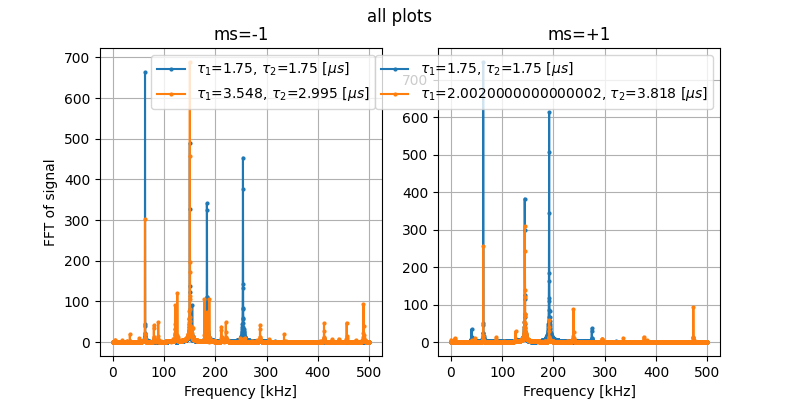

<ipython-input-24-68f1e228495b>:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/5000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


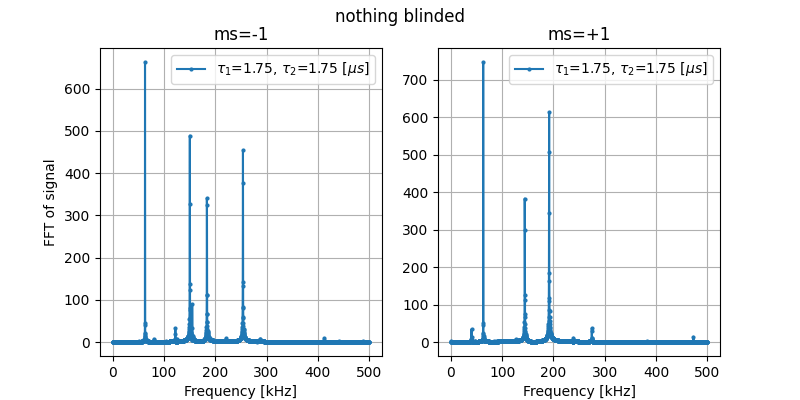

<ipython-input-24-68f1e228495b>:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/5000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


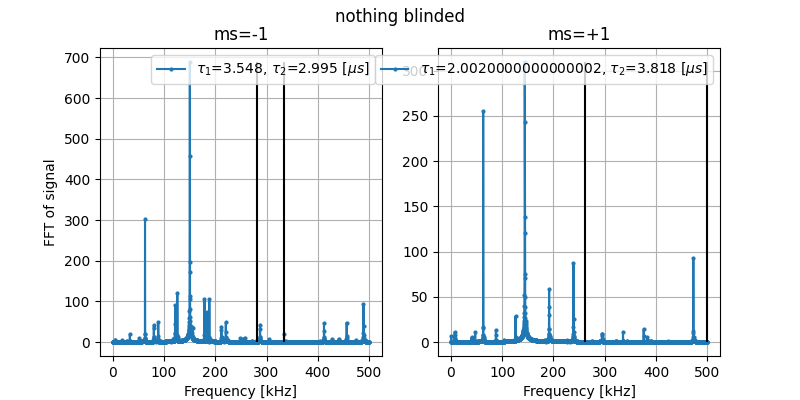

In [24]:
%matplotlib notebook
# determining the parameters
B = 63/1.07 # in Gaus
fL = 1.07*B # kHz
WL = 2*pi*fL # kHz
Azz = np.array([204, -51.5, 55.810, -52.742, -110.035]) # kHz
Azx = np.array([64.4, 143.6, 150.118, 38.919, 185.75]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k_up = Azx / Fh_up
k_dn = Azx / Fh_dn
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('k_up={} kHz'.format(k_up))
print('k_dn={} kHz'.format(k_dn))

dB = 1 # in Gaus
fL_err = 1.07*(B+dB)
Fh_up_err = np.sqrt((fL_err*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up_err = 1/Fh_up_err # in ms

start = 1e-3 # in ms
duration = 5 # in ms
steps = 5000
Tc = np.linspace(start,start+duration, steps) # in ms

sample_rate = steps/duration # in kHz
fig_all,ax_all = plt.subplots(1,2, sharey=False, figsize=(8, 4), dpi=100)
#fig_all.subplots_adjust(wspace=0.08)
for tau1l, tau2l,tau1r, tau2r,txt in [[1.75e-3, 1.75e-3,1.75e-3,1.75e-3, 'nothing blinded'],
                                      [0.55*BS_dn[0], 0.55*BS_dn[1], 0.55*BS_up[0], 0.55*BS_up[1], 'nothing blinded']]:
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in tqdm.tqdm_notebook(Tc):
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one(fL, Azz, Azx, tau1l, tau2l, tc, ms=-1)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]
    ## Finding Max of each peak with filtering
    #from_index, to_index = int(steps/4), int(1.15*steps/4)
    #sub_freqs = freqs[from_index:to_index]
    #sub_FFT_Signal = FFT_Signal[from_index:to_index]
    #x = sub_freqs[np.argmax(sub_FFT_Signal)]
    #y = np.max(sub_FFT_Signal)
    #Max_peaks.append(y)
    ###### ploting part
    fig,ax = plt.subplots(1,2, sharey=False, figsize=(8, 4),dpi=100)
    #fig.subplots_adjust(wspace=0.08)
    fig.suptitle(txt)
    ax[0].set_title('ms=-1')
    ax[1].set_title('ms=+1')
    ax[0].plot(freqs,FFT_Signal,'-o',markersize=2, alpha = 1, label=r'$\tau_1$={},'.format(1e-3*(round(tau1l*1e6)))+
               r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2l*1e6))))
    for i in np.arange(1,10,1):
        if i/tau1l <np.max(freqs):ax[0].vlines(x=i/tau1l,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='black')
        if i/tau2l <np.max(freqs):ax[0].vlines(x=i/tau2l,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='black')
    ax_all[0].plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,label=r'$\tau_1$={},'.format(1e-3*(round(tau1l*1e6)))
                   +r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2l*1e6))) )
    ax[0].set_xlabel('Frequency [kHz]')
    ax[0].set_ylabel('FFT of signal')
    
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in Tc:
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one(fL, Azz, Azx, tau1r, tau2r, tc, ms=1)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]
    ax[1].plot(freqs,FFT_Signal,'-o',markersize=2, alpha = 1, label=r'$\tau_1$={},'.format(1e-3*(round(tau1r*1e6)))+
               r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2r*1e6))))
    for i in np.arange(1,10,1):
        if i/tau1r<np.max(freqs):ax[1].vlines(x=i/tau1r,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='black')
        if i/tau2r<np.max(freqs):ax[1].vlines(x=i/tau2r,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='black')
    ax_all[1].plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,
                label=r'$\tau_1$={},'.format(1e-3*(round(tau1r*1e6)))+r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2r*1e6))) )
    ax[1].set_xlabel('Frequency [kHz]')
    ax[0].grid()
    ax[1].grid()
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='upper right')

ax_all[0].set_title('ms=-1')
ax_all[1].set_title('ms=+1')
fig_all.suptitle('all plots')
ax_all[0].set_xlabel('Frequency [kHz]')
ax_all[1].set_xlabel('Frequency [kHz]')
ax_all[0].set_ylabel('FFT of signal')
ax_all[0].legend(loc='upper right')
ax_all[1].legend(loc='upper right')
ax_all[0].grid()
ax_all[1].grid()

# Let's see the effect of tau1,2 on the amplitude

Freq Larmor=58.229400000000005 kHz
Azz=[204.  -51.5   5.    7.   -3.    2.   -1.    4.   -1.5] kHz
Azx=[ 64.4 143.6   3.   -1.   -5.    1.    4.   -2.    1. ] kHz
Freq hyp up=[270.02151437 143.75759049  63.30052942  65.2370648   55.45526688
  60.23770102  57.36901798  62.26153085  56.73821309] kHz
Freq hyp dn=[159.3625672  180.72493249  53.31387272  51.23915909  61.43321109
  56.23829144  59.3643144   54.26626783  59.7377705 ] kHz
Blind Spot up=[ 3.70340861  6.95615443 15.79765618 15.32870927 18.0325523  16.60089916
 17.43101129 16.06128192 17.62480603] us
Blind Spot dn=[ 6.27499931  5.53327085 18.75684412 19.51632341 16.27784031 17.78147903
 16.84513685 18.42765386 16.73982795] us


<IPython.core.display.Javascript object>


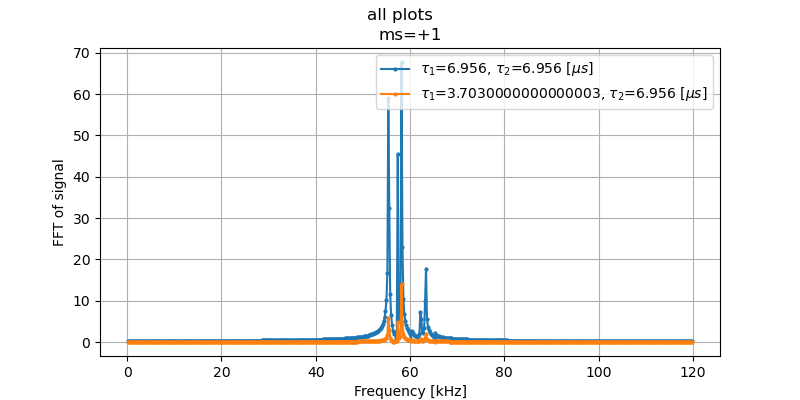

C:\Users\majid\AppData\Local\Temp\ipykernel_3720\1915640845.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


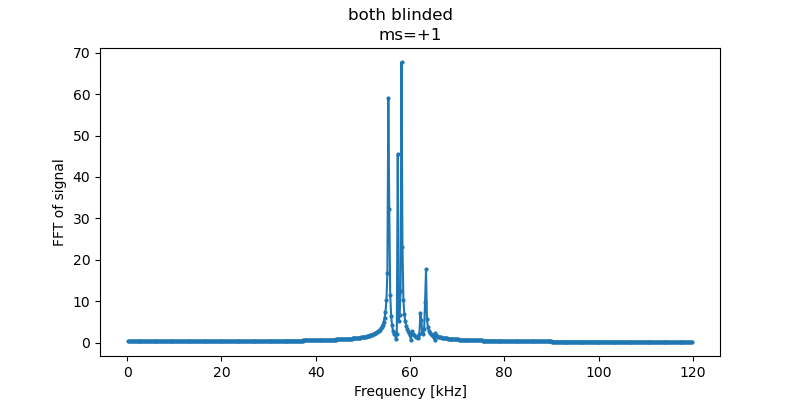

  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


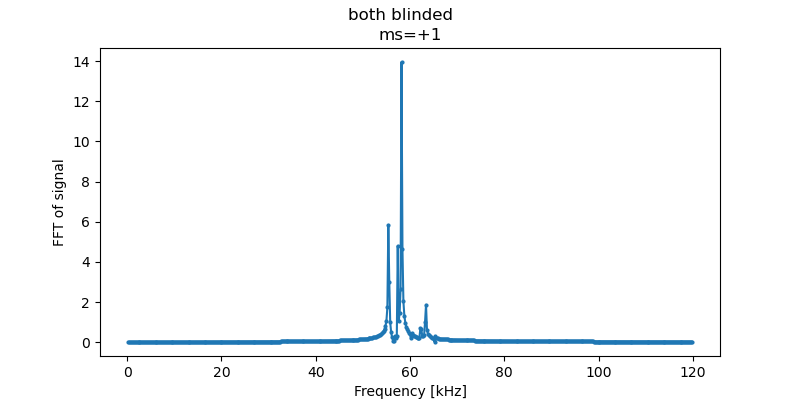

In [11]:
%matplotlib notebook
# determining the parameters
B = 54.42 # in Gaus
fL = 1.07*B # kHz
WL = 2*pi*fL # kHz
Azz = np.array([204, -51.5, 5, 7, -3, 2, -1, 4, -1.5]) # kHz
Azx = np.array([64.4, 143.6, 3, -1, -5, 1, 4, -2, 1]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Blind Spot dn={} us'.format(BS_dn*1000))

dB = 1 # in Gaus
fL_err = 1.07*(B+dB)
Fh_up_err = np.sqrt((fL_err*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up_err = 1/Fh_up_err # in ms

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = np.linspace(start,start+duration, steps) # in ms

sample_rate = steps/duration # in kHz
fig_all,ax_all = plt.subplots(1,1, sharey=True, figsize=(8, 4), dpi=100)
for tau1, tau2,txt in [[6.95615e-3, 6.95615e-3, 'both blinded'],
                       [BS_up[0], BS_up[1], 'both blinded']]:
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in tqdm.tqdm_notebook(Tc):
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one(fL, Azz, Azx, tau1, tau2, tc, ms=+1)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]
    ## Finding Max of each peak with filtering
    #from_index, to_index = int(steps/4), int(1.15*steps/4)
    #sub_freqs = freqs[from_index:to_index]
    #sub_FFT_Signal = FFT_Signal[from_index:to_index]
    #x = sub_freqs[np.argmax(sub_FFT_Signal)]
    #y = np.max(sub_FFT_Signal)
    #Max_peaks.append(y)
    ###### ploting part
    fig,ax = plt.subplots(1,1, sharey=True, figsize=(8, 4),dpi=100)
    fig.suptitle(txt)
    ax.set_title('ms=+1')
    ax.plot(freqs,FFT_Signal,'-o',markersize=2, alpha = 1, label=r'$\tau_1$={},'.format(1e-3*(round(tau1*1e6)))+
               r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2*1e6))))
    for i in np.arange(1,10,1):
        if i/tau1 <np.max(freqs):ax.vlines(x=i/tau1,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='black')
        if i/tau2 <np.max(freqs):ax.vlines(x=i/tau2,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='black')
    ax_all.plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,label=r'$\tau_1$={},'.format(1e-3*(round(tau1*1e6)))
                   +r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2*1e6))) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')

    

ax_all.set_title('ms=+1')
fig_all.suptitle('all plots')
ax_all.set_xlabel('Frequency [kHz]')
ax_all.set_xlabel('Frequency [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend(loc='upper right')
ax_all.legend(loc='upper right')
ax_all.grid()

# Let's go to different BS and find the highest amplitude for a wavelength

In [12]:
%matplotlib notebook
# determining the parameters
B = 63/1.07 # in Gaus
fL = 1.07*B # kHz
WL = 2*pi*fL # kHz
#Azz = np.array([204, -51.5, 85.51, 5, 7, -3, 2, -1, 4, -1.5]) # kHz
#Azx = np.array([64.4, 143.6, 120.11, 3, -1, -5, 1, 4, -2, 1]) # kHz
Azz = np.array([204, -51.5, 5, 7, -3, 2, -1, 4, -1.5]) # kHz
Azx = np.array([64.4, 143.6, 3, -1, -5, 1, 4, -2, 1]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Blind Spot dn={} us'.format(BS_dn*1000))

dB = 1 # in Gaus
fL_err = 1.07*(B+dB)
Fh_up_err = np.sqrt((fL_err*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up_err = 1/Fh_up_err # in ms

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = np.linspace(start,start+duration, steps) # in ms

sample_rate = steps/duration # in kHz
Max_amp2d = []
Taus1 = BS_dn[1]*np.arange(1,10,1)
Taus2 = BS_dn[1]*np.arange(1,10,1)
for tau1 in tqdm.tqdm_notebook(Taus1):
    Max_amp1d = []
    for tau2 in Taus2:
        Term1 = []
        Term2 = []
        Term3 = []
        Term4 = []
        Signal = []

        for tc in Tc:
            [signal, term1 , term2, term3, term4]= anal_eseem_spin_one(fL, Azz, Azx, tau1, tau2, tc, ms=-1)
            Term1.append(term1)
            Term2.append(term2)
            Term3.append(term3)
            Term4.append(term4)
            Signal.append(signal)

        freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/5)]
        FFT_Signal = np.abs(np.fft.rfft(Signal))[1:int(steps/5)]
        Max_amp1d.append(max(FFT_Signal))
    Max_amp2d.append(Max_amp1d)
Max_amp2d=np.array(Max_amp2d)    

Freq Larmor=63.0 kHz
Azz=[204.  -51.5   5.    7.   -3.    2.   -1.    4.   -1.5] kHz
Azx=[ 64.4 143.6   3.   -1.   -5.    1.    4.   -2.    1. ] kHz
Freq hyp up=[274.65680403 144.05974455  68.0661443   70.00714249  60.20797289
  65.00769185  62.12889827  67.0298441   61.50812954] kHz
Freq hyp dn=[155.01083833 183.66058369  58.07753438  56.00892786  66.18912297
  61.00819617  64.12487817  59.03388857  64.50775147] kHz
Blind Spot up=[ 3.64090744  6.94156444 14.69159169 14.28425678 16.60909597 15.38279504
 16.0955695  14.91872782 16.25801349] us
Blind Spot dn=[ 6.45116181  5.44482643 17.21836181 17.85429642 15.10822255 16.39124024
 15.59457154 16.93942283 15.50201297] us


C:\Users\majid\AppData\Local\Temp\ipykernel_3720\2051015275.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tau1 in tqdm.tqdm_notebook(Taus1):


  0%|          | 0/9 [00:00<?, ?it/s]

Max amplitude is = 1265.4336099619773
Optimum order BS_dn[1] = 4.0
Optimum order BS_dn[1] = 4.0


<IPython.core.display.Javascript object>


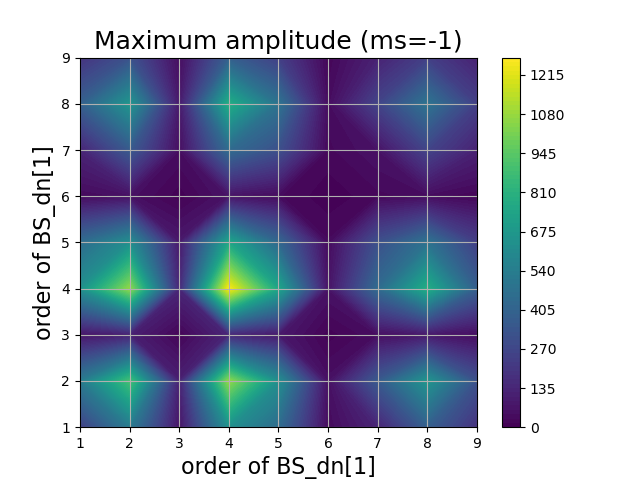

In [13]:
y,x=np.meshgrid(Taus2/BS_dn[1],Taus1/BS_dn[1])
print("Max amplitude is = {}".format(np.max(Max_amp2d)))
result=np.where(Max_amp2d == np.amax(Max_amp2d))
listOfCordinates = list(zip(result[0], result[1]))
for cord in listOfCordinates:
    if Max_amp2d[cord[0]][cord[1]]==np.max(Max_amp2d):
        print('Optimum order BS_dn[1] = {}'.format(x[cord[0]][cord[1]]))
        print('Optimum order BS_dn[1] = {}'.format(y[cord[0]][cord[1]]))
    else: print('max did not calculated correctly')
plt.figure(dpi=100)
plt.contourf(x, y, Max_amp2d,100)
plt.title('Maximum amplitude (ms=-1)', fontsize =18)
plt.xlabel('order of BS_dn[1]', fontsize=16)
plt.ylabel('order of BS_dn[1]', fontsize =16)
plt.colorbar()
plt.grid()

# Let's confirm the optimum Blind spots

<IPython.core.display.Javascript object>


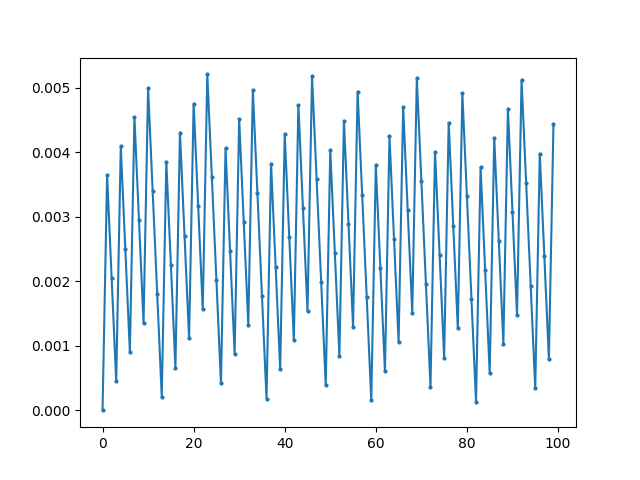

1.5029370687468337
0.11434135500661655


In [55]:
integers = np.arange(100)
residual =[]
for i in integers:
    residual.append((BS_up[0]*i)%BS_up[2])

fig,ax = plt.subplots(dpi=100)
ax.plot(integers, residual,'-o',markersize=2, alpha = 1)
print((BS_dn[2]*1)/BS_dn[1])
print(BS_dn[1]*21)

Freq Larmor=63.0 kHz
Azz=[204.  -51.5   5.    7.   -3.    2.   -1.    4.   -1.5] kHz
Azx=[ 64.4 143.6   3.   -1.   -5.    1.    4.   -2.    1. ] kHz
Freq hyp up=[274.65680403 144.05974455  68.0661443   70.00714249  60.20797289
  65.00769185  62.12889827  67.0298441   61.50812954] kHz
Freq hyp dn=[155.01083833 183.66058369  58.07753438  56.00892786  66.18912297
  61.00819617  64.12487817  59.03388857  64.50775147] kHz
Blind Spot up=[ 3.64090744  6.94156444 14.69159169 14.28425678 16.60909597 15.38279504
 16.0955695  14.91872782 16.25801349] us
Blind Spot dn=[ 6.45116181  5.44482643 17.21836181 17.85429642 15.10822255 16.39124024
 15.59457154 16.93942283 15.50201297] us


<IPython.core.display.Javascript object>


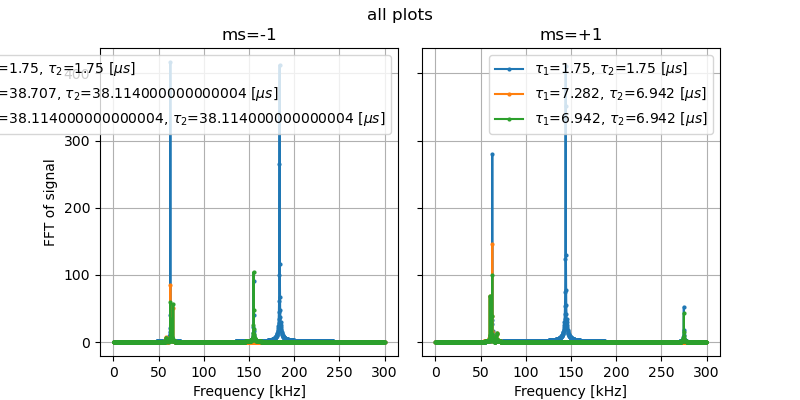

C:\Users\majid\AppData\Local\Temp\ipykernel_3720\1434371847.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


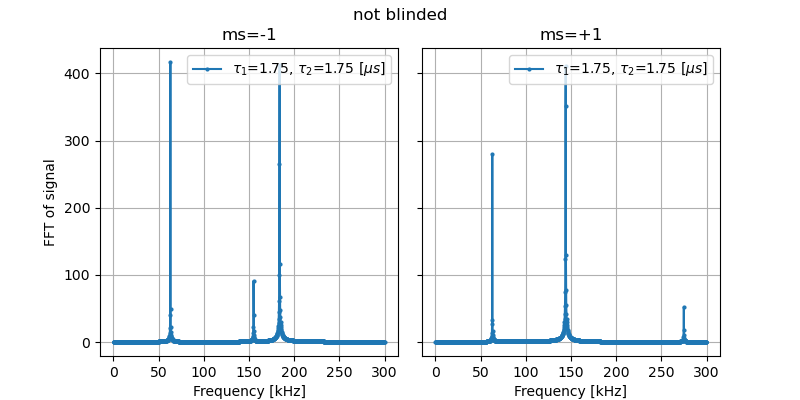

  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


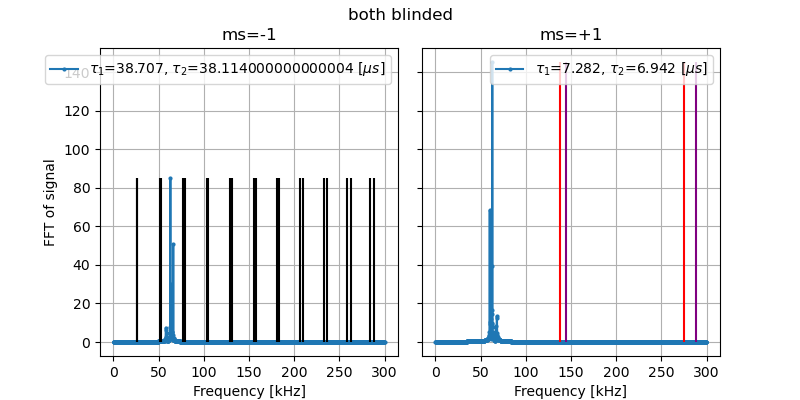

  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


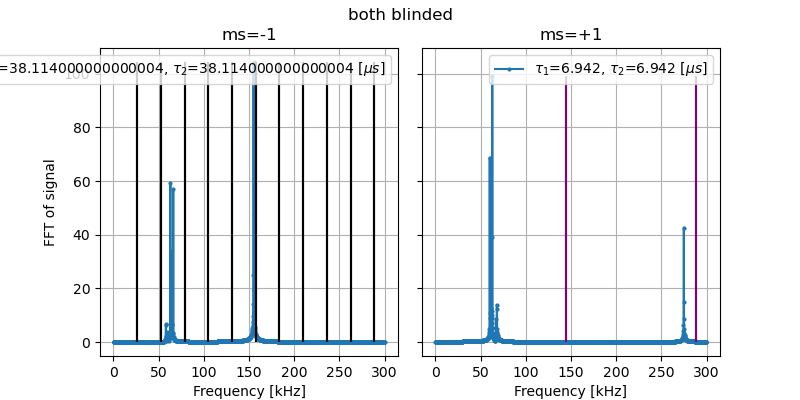

In [14]:
%matplotlib notebook
# determining the parameters
B = 63/1.07 # in Gaus
fL = 1.07*B # kHz
WL = 2*pi*fL # kHz
#Azz = np.array([204, -51.5, 85.51, 5, 7, -3, 2, -1, 4, -1.5]) # kHz
#Azx = np.array([64.4, 143.6, 120.11, 3, -1, -5, 1, 4, -2, 1]) # kHz
Azz = np.array([204, -51.5, 5, 7, -3, 2, -1, 4, -1.5]) # kHz
Azx = np.array([64.4, 143.6, 3, -1, -5, 1, 4, -2, 1]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Blind Spot dn={} us'.format(BS_dn*1000))

dB = 1 # in Gaus
fL_err = 1.07*(B+dB)
Fh_up_err = np.sqrt((fL_err*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up_err = 1/Fh_up_err # in ms

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = np.linspace(start,start+duration, steps) # in ms

sample_rate = steps/duration # in kHz
fig_all,ax_all = plt.subplots(1,2, sharey=True, figsize=(8, 4), dpi=100)
fig_all.subplots_adjust(wspace=0.08)
for tau1l, tau2l,tau1r, tau2r,txt in [[1.75e-3, 1.75e-3, 1.75e-3, 1.75e-3, 'not blinded'],
                                      [6*BS_dn[0], 7*BS_dn[1], 2*BS_up[0], 1*BS_up[1], 'both blinded'],
                                     [7*BS_dn[1], 7*BS_dn[1], 1*BS_up[1], 1*BS_up[1], 'both blinded']]:
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in tqdm.tqdm_notebook(Tc):
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one(fL, Azz, Azx, tau1l, tau2l, tc, ms=-1)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]
    ## Finding Max of each peak with filtering
    #from_index, to_index = int(steps/4), int(1.15*steps/4)
    #sub_freqs = freqs[from_index:to_index]
    #sub_FFT_Signal = FFT_Signal[from_index:to_index]
    #x = sub_freqs[np.argmax(sub_FFT_Signal)]
    #y = np.max(sub_FFT_Signal)
    #Max_peaks.append(y)
    ###### ploting part
    fig,ax = plt.subplots(1,2, sharey=True, figsize=(8, 4),dpi=100)
    fig.subplots_adjust(wspace=0.08)
    fig.suptitle(txt)
    ax[0].set_title('ms=-1')
    ax[1].set_title('ms=+1')
    ax[0].plot(freqs,FFT_Signal,'-o',markersize=2, alpha = 1, label=r'$\tau_1$={},'.format(1e-3*(round(tau1l*1e6)))+
               r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2l*1e6))))
    for i in np.arange(1,50,1):
        if i/tau1l <np.max(freqs):ax[0].vlines(x=i/tau1l,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='black')
        if i/tau2l <np.max(freqs):ax[0].vlines(x=i/tau2l,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='black')
    ax_all[0].plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,label=r'$\tau_1$={},'.format(1e-3*(round(tau1l*1e6)))
                   +r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2l*1e6))) )
    ax[0].set_xlabel('Frequency [kHz]')
    ax[0].set_ylabel('FFT of signal')
    
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in Tc:
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one(fL, Azz, Azx, tau1r, tau2r, tc, ms=1)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]
    ax[1].plot(freqs,FFT_Signal,'-o',markersize=2, alpha = 1, label=r'$\tau_1$={},'.format(1e-3*(round(tau1r*1e6)))+
               r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2r*1e6))))
    for i in np.arange(1,50,1):
        if i/tau1r<np.max(freqs):ax[1].vlines(x=i/tau1r,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='red')
        if i/tau2r<np.max(freqs):ax[1].vlines(x=i/tau2r,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='purple')
    ax_all[1].plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,
                label=r'$\tau_1$={},'.format(1e-3*(round(tau1r*1e6)))+r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2r*1e6))) )
    ax[1].set_xlabel('Frequency [kHz]')
    ax[0].grid()
    ax[1].grid()
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='upper right')
    #ax[0].set_yscale('log')

ax_all[0].set_title('ms=-1')
ax_all[1].set_title('ms=+1')
fig_all.suptitle('all plots')
ax_all[0].set_xlabel('Frequency [kHz]')
ax_all[1].set_xlabel('Frequency [kHz]')
ax_all[0].set_ylabel('FFT of signal')
ax_all[0].legend(loc='upper right')
ax_all[1].legend(loc='upper right')
ax_all[0].grid()
ax_all[1].grid()

In [126]:
7*5.44482643  

38.11378501

## Now, we see how the amplitude of the peak changes with tau

In [197]:
%matplotlib notebook
# determining the parameters
fL = 1.07*62.9 # kHz
WL = 2*pi*fL # kHz
Azz = np.array([204, -51.5, 5, 7, 3, 2, 1, 4, 1.5]) # kHz
Azx = np.array([64.4, 143.6, 3, 1, 5, 1, 4, 2, 1]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} us'.format(BS_dn*1000))

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = np.linspace(start,start+duration, steps) # in ms

sample_rate = steps/duration # in kHz
#fig_all,ax_all = plt.subplots(dpi=100)
Max_peaks = []
Taus = np.linspace(0.5*BS_up[0],10.5*BS_up[0],100)
for tau1 in Taus:
    tau2 = tau1
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in tqdm.tqdm_notebook(Tc):
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one(fL, Azz, Azx, tau1, tau2, tc, ms=1)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]
    ## Finding Max of each peak with filtering
    from_index, to_index = int(steps/4), int(1.15*steps/4)
    sub_freqs = freqs[from_index:to_index]
    sub_FFT_Signal = FFT_Signal[from_index:to_index]
    x = sub_freqs[np.argmax(sub_FFT_Signal)]
    y = np.max(sub_FFT_Signal)
    Max_peaks.append(y)
    ###### ploting part
    #fig,ax = plt.subplots(dpi=100)
    #plt.title(r'$\tau_1$={},'.format(1e-3*(round(tau1*1e6)))+r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2*1e6))))
    #ax.plot(freqs,FFT_Signal,'-o',markersize=2, alpha = 1)
    #ax_all.plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,
    #            label=r'$\tau_1$={},'.format(1e-3*(round(tau1*1e6)))+r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2*1e6))) )
    #ax.set_xlabel('Frequency [kHz]')
    #ax.set_ylabel('FFT of signal')
    #ax_all.plot(x,y,'x', markersize=10, label='max')
    
#ax_all.set_xlabel(r'$\omega$ [kHz]')
#ax_all.set_ylabel('FFT of signal')
#ax_all.legend()

Freq Larmor=57.94799 kHz
Azz=[-204.    51.5] kHz
Azx=[ 64.4 143.6] kHz
Freq hyp up=[159.62001637 180.55420935] kHz
Blind Spot up=[6.26487845 5.53850283] us
Freq hyp dn=[269.74823348 143.74469234] kHz
Blind Spot dn=[3.70716051 6.9567786 ] us


C:\Users\yy3\AppData\Local\Temp\ipykernel_17088\822982750.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


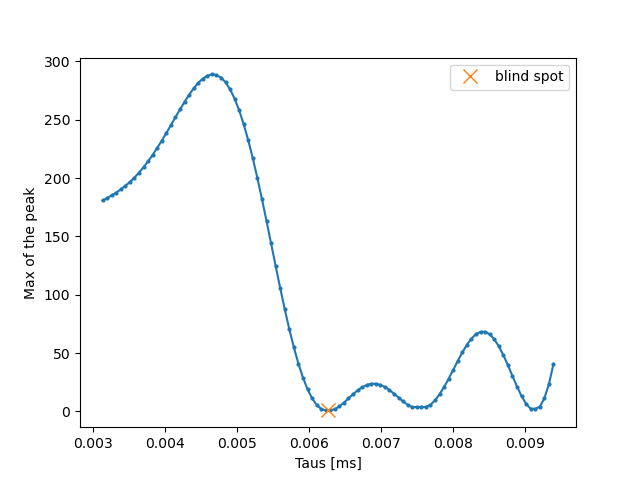

In [198]:
fig,ax = plt.subplots(dpi=100)
ax.plot(Taus, Max_peaks,'-o', markersize=2)
ax.plot(BS_up[0], Max_peaks[50], 'x', markersize=10, label='blind spot')
ax.set_xlabel('Taus [ms]')
ax.set_ylabel('Max of the peak')
ax.legend()

In [ ]:
def anal_max_peak(fL, Azz, Azx, target_index, ms=1):
    FL = fL*np.ones_like(Azz,dtype=float)
    Ome_a = 2*pi*np.sqrt((FL+ms*Azz)**2+Azx**2) ## Here is the only place we assume spin 1
    Ome_b = 2*pi*FL                                ## Here is the only place we assume spin 1
    Ome_plus = Ome_a + Ome_b
    Ome_minu = Ome_a - Ome_b
    
    Eta_a = np.arctan((ms*Azx)/(fL+ms*Azz))   ## specific for spin 1
    Eta_b = 0                                 ## specific for spin 1
    Eta = (Eta_a - Eta_b)/2        
    K = sin(2*Eta)**2
    

In [207]:
57.8**2*1e-4

0.334084

In [4]:
B = 57 # in Gaus
fL = 1.07*B # kHz
WL = 2*pi*fL # kHz
Azz = np.array([204, -51.5, 10, 2 , 3, 4, 2.8]) # kHz
Azx = np.array([64.4, 143.6, 8, 5, 1, 2, 3]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} us'.format(BS_dn*1000))

Freq Larmor=60.99 kHz
Azz=[204.  -51.5  10.    2.    3.    4.    2.8] kHz
Azx=[ 64.4 143.6   8.    5.    1.    2.    3. ] kHz
Freq hyp up=[272.70324549 143.9132381   71.4393456   63.18813259  63.99781324
  65.02076668  63.86050501] kHz
Blind Spot up=[ 3.66698973  6.94863109 13.99788858 15.8257565  15.62553389 15.37970176
 15.65913079] us
Freq hyp dn=[156.84138516 182.4142541   51.61375882  59.2015211   57.99862154
  57.02508308  58.26728156] kHz
Blind Spot dn=[ 6.3758682   5.48202773 19.37467882 16.89145788 17.24178909 17.5361428
 17.16229028] us


# Lattice site finding

In [72]:
import mbuild as mb
import numpy as np

# define all necessary lattice parameters
#spacings = [0.54309, 0.54309, 0.54309]
spacings = [0.3567, 0.3567, 0.3567]
angles = [90, 90, 90]
points = [[0, 0, 0], [0.5, 0.5, 0], [0.5, 0, 0.5], [0, 0.5, 0.5],
          [0.25, 0.25, 0.75], [0.25, 0.75, 0.25], [0.75, 0.25, 0.25], [0.75, 0.75, 0.75]]

# define lattice object
diamond_lattice = mb.Lattice(lattice_spacing=spacings, angles=angles, lattice_points={'A' : points})

# define Compound
C = mb.Compound(name='C')

# populate lattice with compounds
C_lattice = diamond_lattice.populate(compound_dict={'A' : si}, x=2, y=2, z=2)

# visualize
si_lattice.visualize()

ModuleNotFoundError: No module named 'mbuild'

In [74]:
 conda install -c conda-forge mbuild

^C

Note: you may need to restart the kernel to use updated packages.
